In [1]:
# !pip install pycaret[tuners]

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from itertools import combinations
from xgboost import XGBClassifier
import re
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, finalize_model, predict_model, save_model, load_model
import warnings
warnings.filterwarnings("ignore")

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
path = "C:/Users/Alber/OneDrive/Documentos/MACHINE LEARNING ENGINEERING/Parcial 1/Parcial1/data/"

In [5]:
%%time
df = pd.read_csv(path  + 'train.csv')
prueba = pd.read_csv(path + "test.csv")

ct = ["Marital status","Daytime/evening attendance","Nacionality","Mother's occupation","Father's occupation",
"Displaced","Educational special needs","Debtor","Tuition fees up to date","Gender","Scholarship holder","International",
"Application mode","Application order"]
for k in ct:
  df[k] = df[k].astype("O")
  prueba[k] = prueba[k].astype("O")

CPU times: total: 375 ms
Wall time: 553 ms


In [6]:
prueba.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,8,0,0,0.000000,0,13.9,-0.3,0.79
1,76519,1,1,1,9238,1,1,128.0,1,1,...,0,0,6,6,6,13.500000,0,11.1,0.6,2.02
2,76520,1,1,1,9238,1,1,118.0,1,1,...,0,0,6,11,5,11.000000,0,15.5,2.8,-4.06
3,76521,1,44,1,9147,1,39,130.0,1,1,...,0,3,8,14,5,11.000000,0,8.9,1.4,3.51
4,76522,1,39,1,9670,1,1,110.0,1,1,...,0,0,6,9,4,10.666667,2,7.6,2.6,0.32


In [7]:
df.shape

(76518, 38)

## Train

In [8]:
ft = pd.DataFrame(df.isnull().sum()).reset_index()
ft.columns = ["Variable","Faltantes"]
ft["% Faltantes"] = ft["Faltantes"] * 100 / df.shape[0]
ft.loc[ft["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [9]:
formato = pd.DataFrame({'Variable': list(df.columns), 'Formato': df.dtypes })
ft = pd.merge(ft,formato,on=["Variable"],how="left")
ft.head()

,Variable,Faltantes,% Faltantes,Formato
0,id,0,0.0,int64
1,Marital status,0,0.0,object
2,Application mode,0,0.0,object
3,Application order,0,0.0,object
4,Course,0,0.0,int64


## Test

In [10]:
ft2 = pd.DataFrame(prueba.isnull().sum()).reset_index()
ft2.columns = ["Variable","Faltantes"]
ft2["% Faltantes"] = ft2["Faltantes"] * 100 / prueba.shape[0]
ft2.loc[ft2["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


## Análisis descriptivo

In [11]:
cuantitativas = list(formato.loc[formato["Formato"]!="object","Variable"])
cuantitativas = [x for x in cuantitativas if x not in ["id","Target"]]

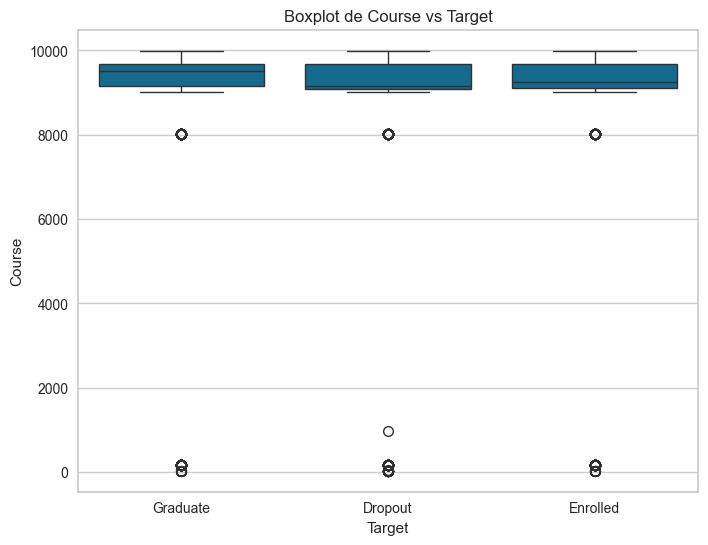

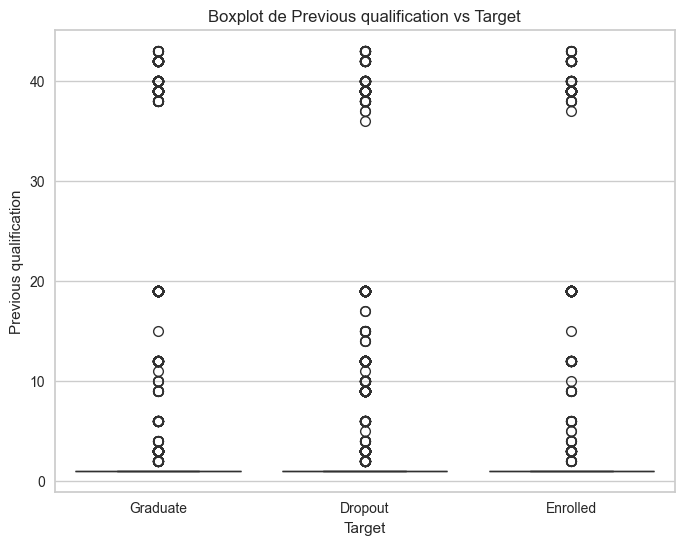

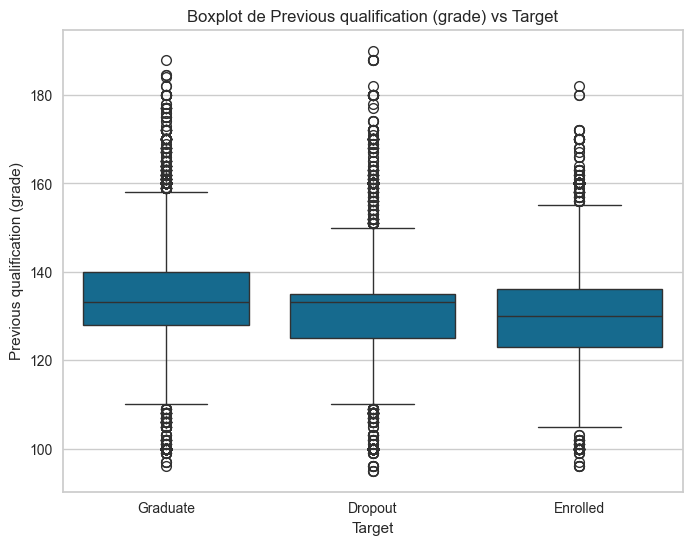

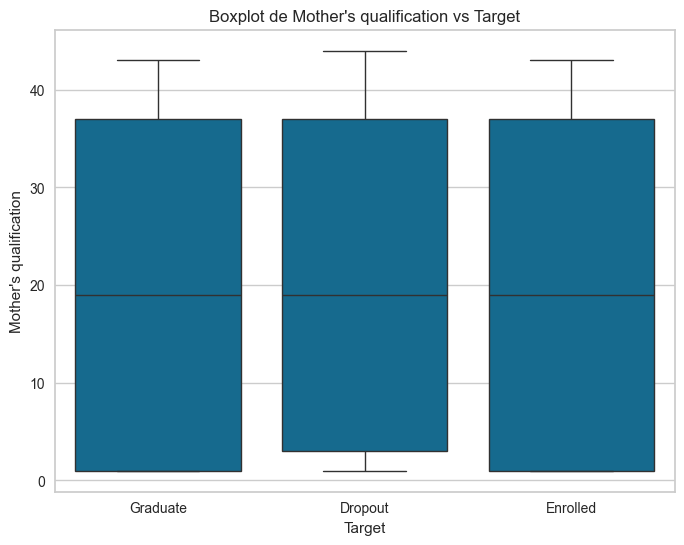

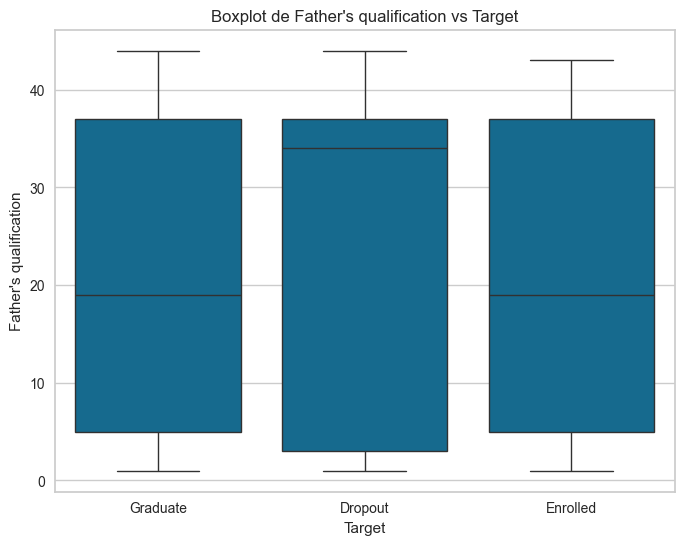

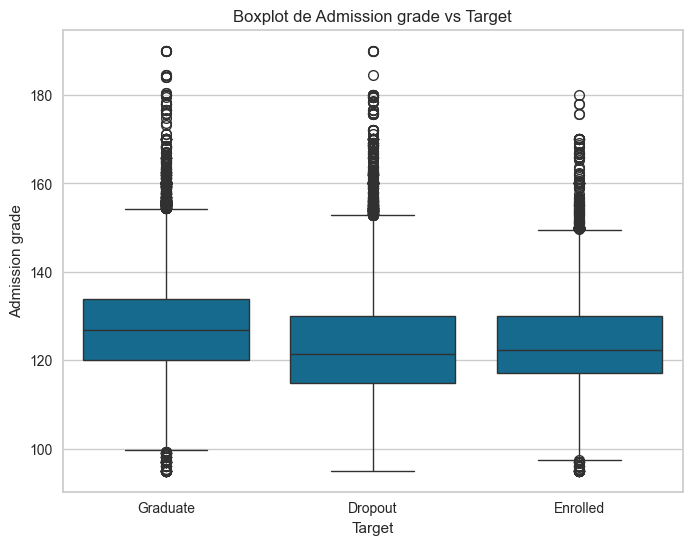

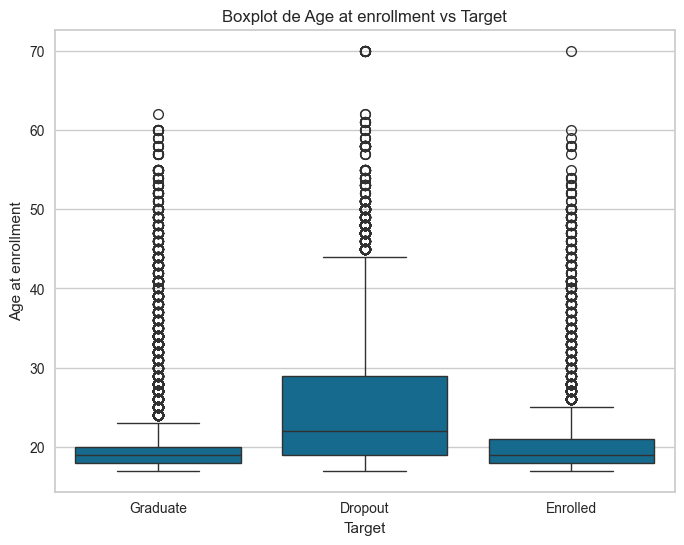

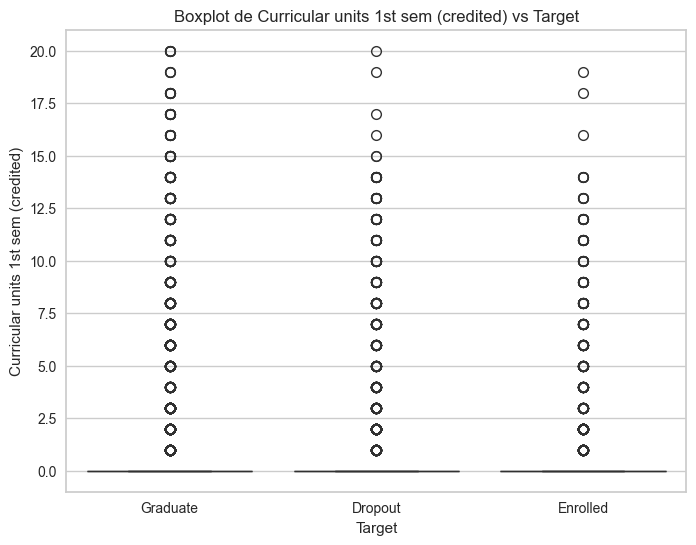

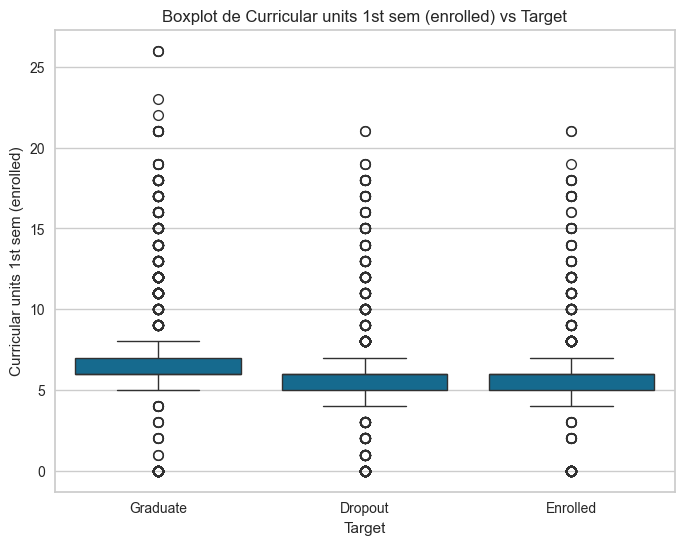

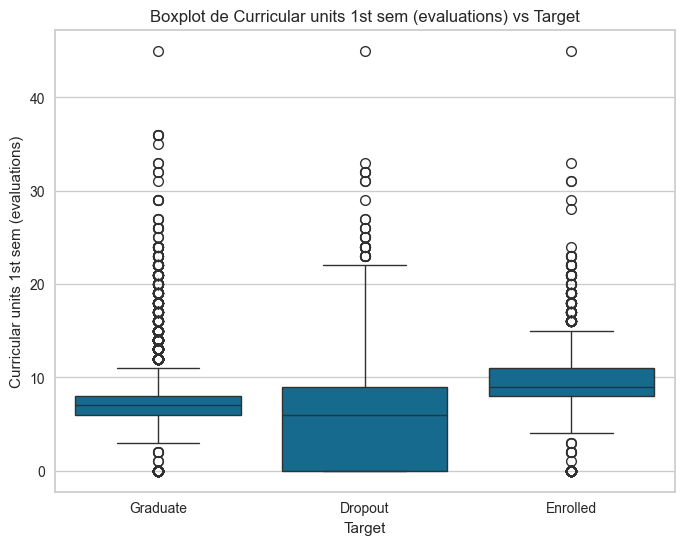

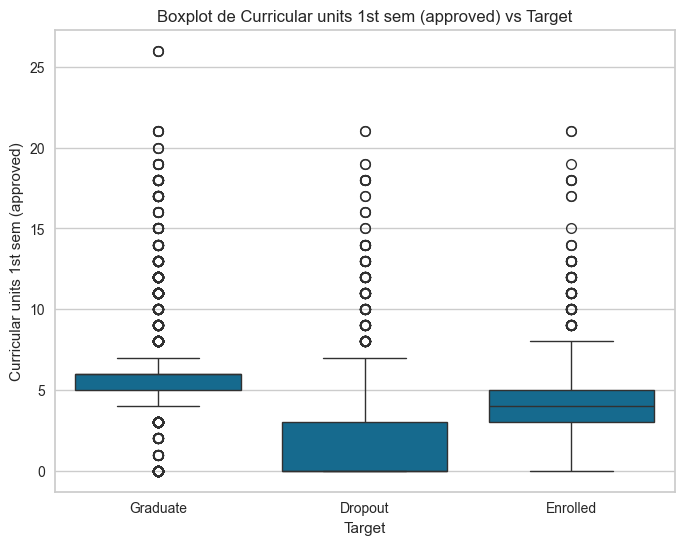

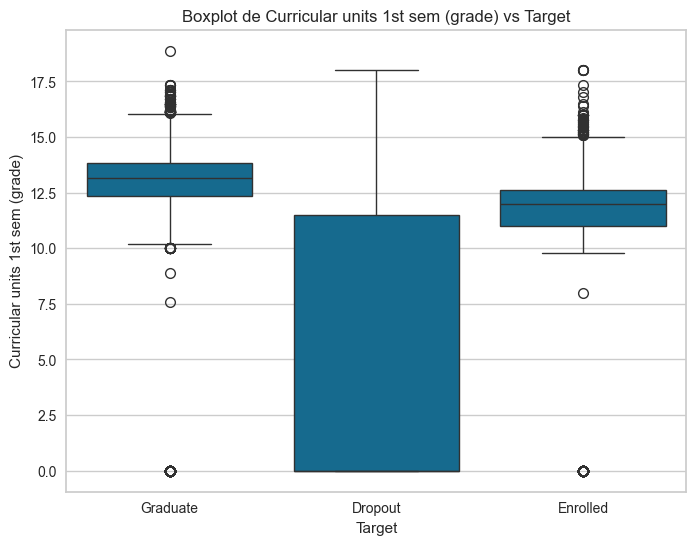

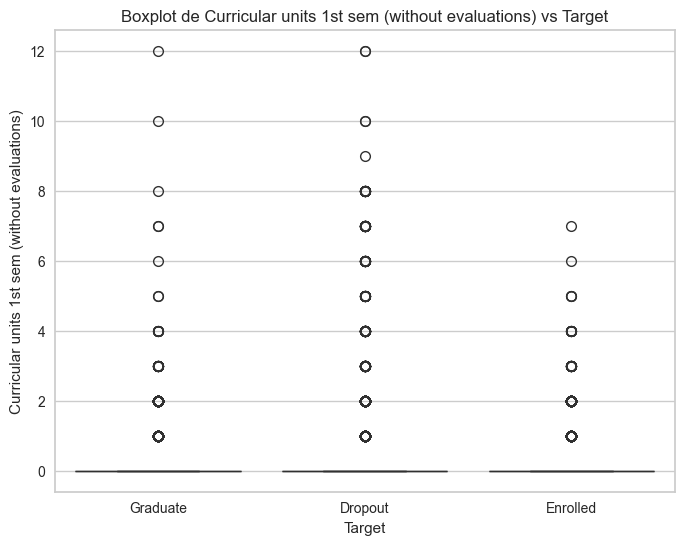

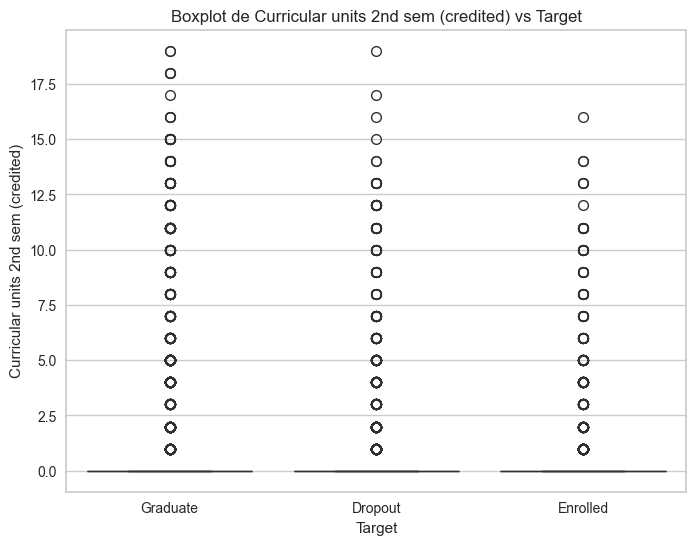

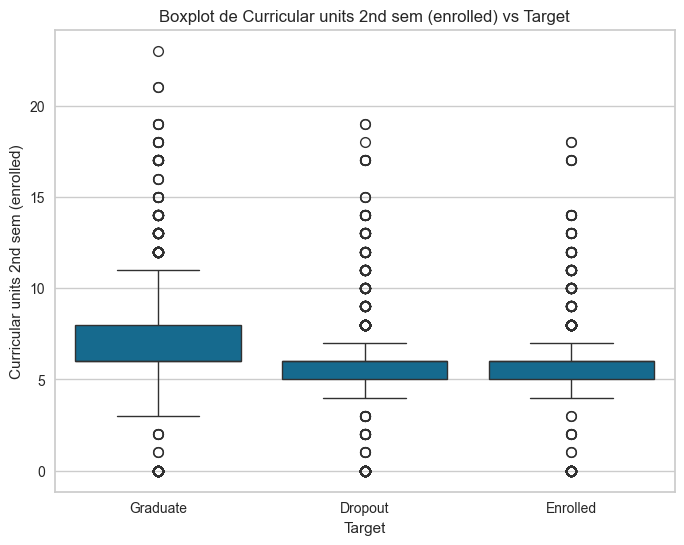

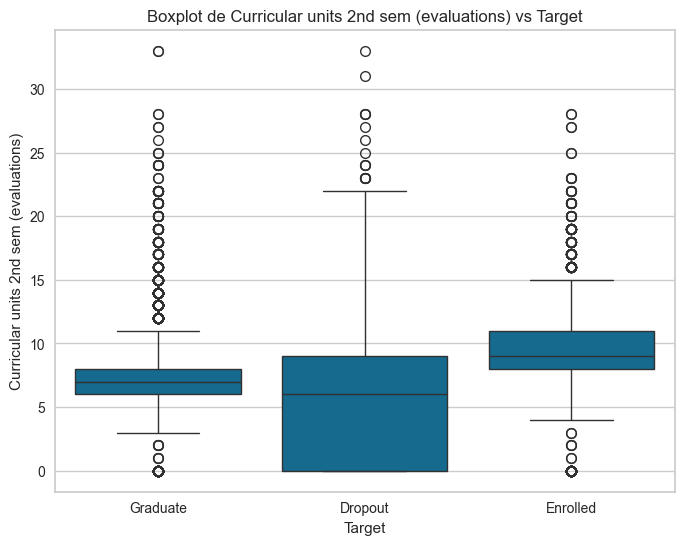

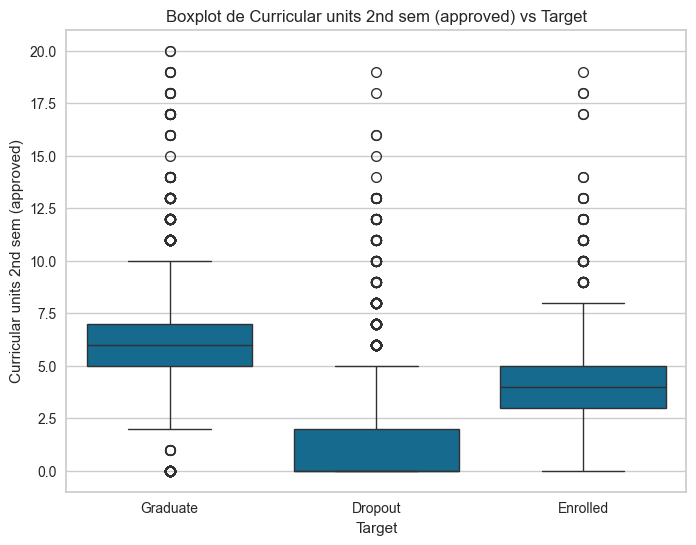

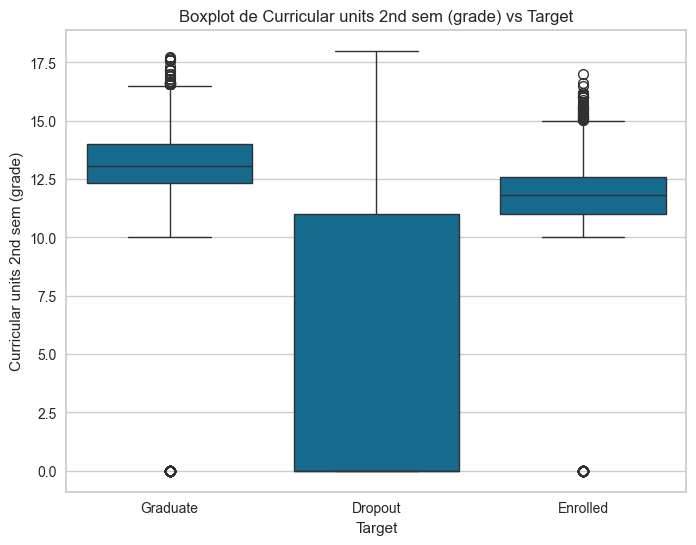

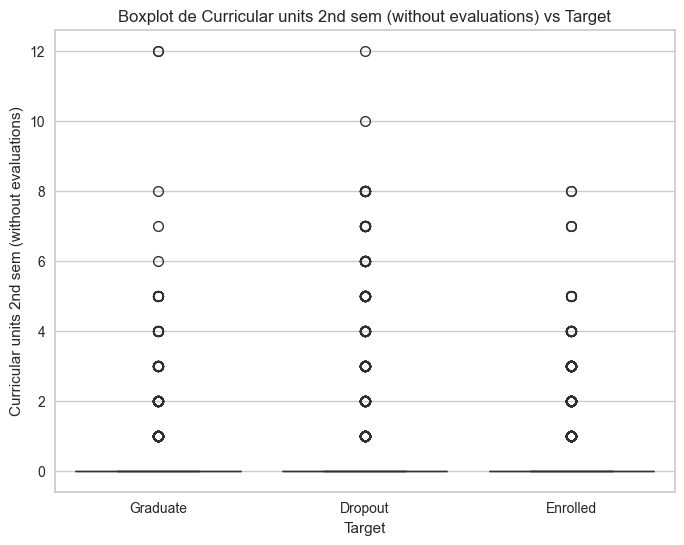

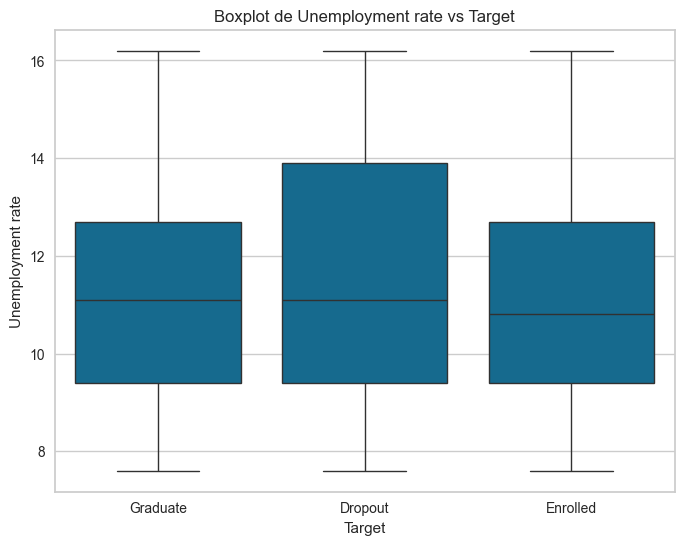

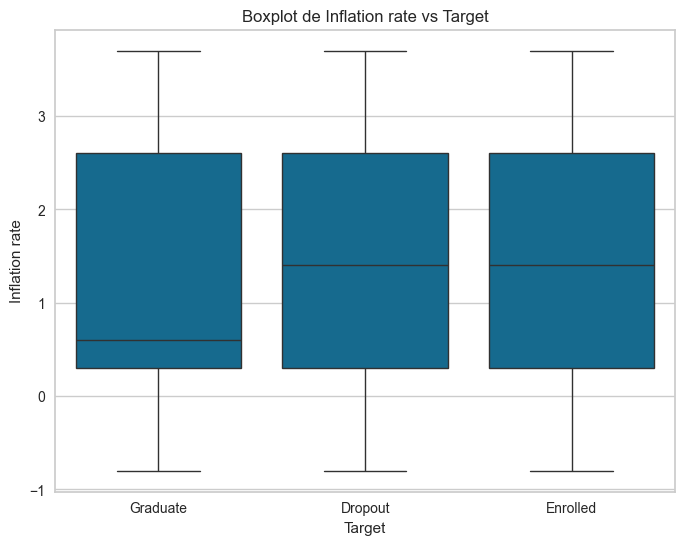

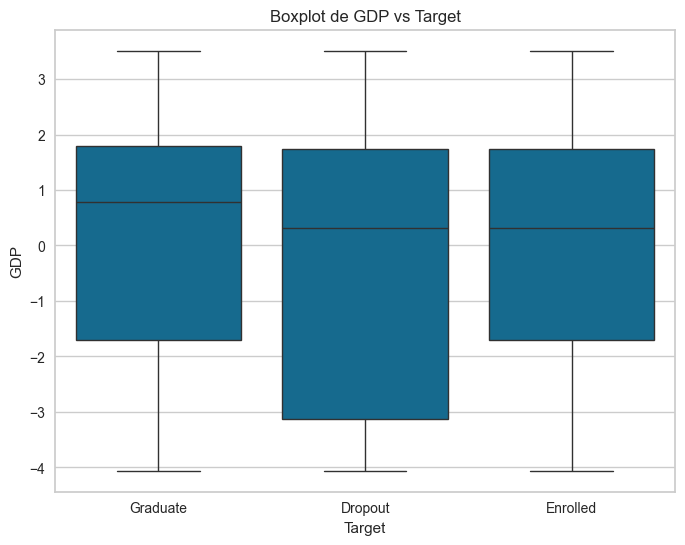

In [12]:
for k in cuantitativas:
    plt.figure(figsize=(8,6))
    sns.boxplot(x="Target",y=k,data=df)
    plt.title("Boxplot de "+k+" vs Target")

In [13]:
def asociacion(data):
    categoricas=data.columns[data.dtypes=='O']
    V1=np.array(categoricas); V2=np.array(categoricas)
    grilla=np.meshgrid(V1,V2)
    grilla=pd.DataFrame({'Var1':grilla[0].ravel(),'Var2':grilla[1].ravel()})
    p_value=[stats.chi2_contingency(pd.DataFrame(pd.crosstab(data[grilla.iloc[x]['Var1']],data[grilla.iloc[x]['Var2']])))[1] for x in range(grilla.shape[0])]

    grilla['p_value']=p_value
    grilla2=grilla.pivot(index='Var1',columns='Var2',values='p_value')
    plt.figure(figsize=(10,8))
    gr=sns.heatmap(grilla2,linewidths=0.01,annot=True,fmt='.2f',cmap='summer')
    gr.set_title('Grilla de p valores en prueba chi cuadrado para verificar asociación entre variables')
    plt.xlabel(""); plt.ylabel(""); plt.yticks(rotation=0); plt.xticks(rotation=90)
    plt.show()
    return grilla,grilla2

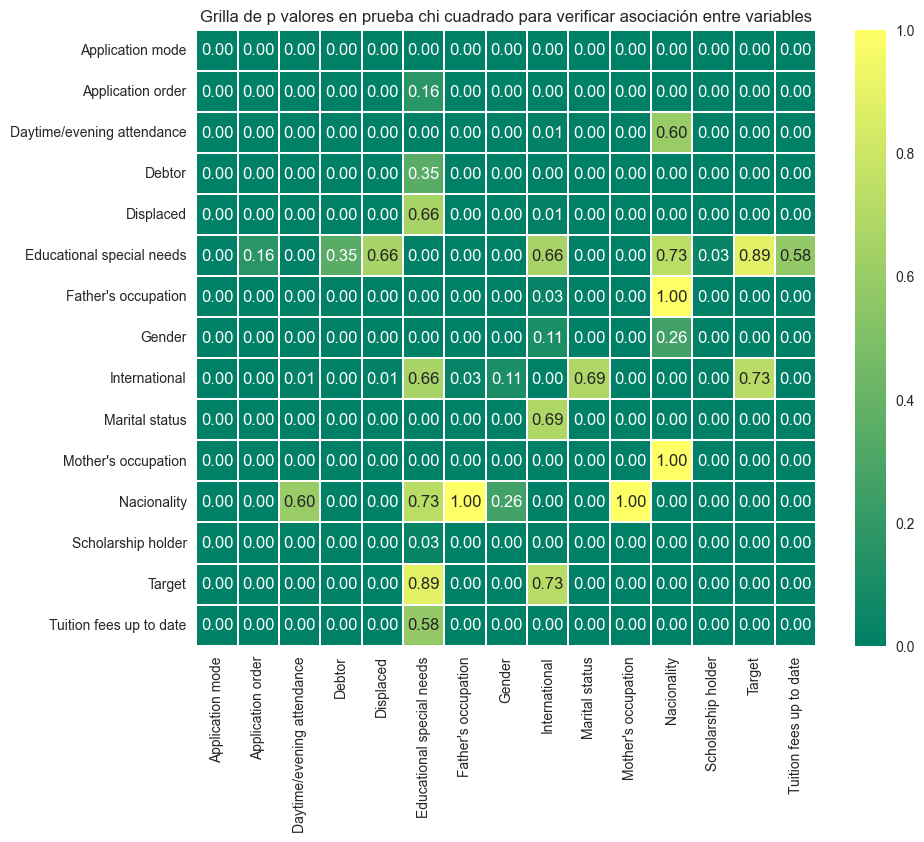

In [14]:
grilla_asociacion, grilla_asociacion2 = asociacion(df.drop(["id"],axis=1))

## Ingeniería de variables

### variables al cuadrado

In [15]:
def prueba_kr(x):
  if x<=0.10:
    return 1
  else:
    return 0

def criterion_(df,columns):
  for k in columns:
    df[k] = df[k].map(prueba_kr)
  df["criterio"] = np.sum(df.get(columns),axis=1)
  df["criterio"] = df.apply(lambda row: 1 if row["criterio"]==3 else 0,axis = 1)
  return df

In [16]:
df["Target"].unique()

array(['Graduate', 'Dropout', 'Enrolled'], dtype=object)

In [17]:
base_cuadrado = df.get(cuantitativas).copy()
base_cuadrado["Target"] = df["Target"].copy()

var_names2, pvalue1, pvalue2, pvalue3 = [], [], [], []

for k in cuantitativas:
    base_cuadrado[k+"_2"] = base_cuadrado[k] ** 2

    # Prueba de Kruskal sin logaritmo
    mue1 = base_cuadrado.loc[base_cuadrado["Target"]=="Graduate",k+"_2"].to_numpy()
    mue2 = base_cuadrado.loc[base_cuadrado["Target"]=="Dropout",k+"_2"].to_numpy()
    mue3 = base_cuadrado.loc[base_cuadrado["Target"]=="Enrolled",k+"_2"].to_numpy()

    p1 = stats.kruskal(mue1,mue2)[1]
    p2 = stats.kruskal(mue1,mue3)[1]
    p3 = stats.kruskal(mue2,mue3)[1]

    # Guardar p values y variables
    var_names2.append(k+"_2")
    pvalue1.append(np.round(p1,2))
    pvalue2.append(np.round(p2,2))
    pvalue3.append(np.round(p3,2))

In [18]:
pcuadrado1 = pd.DataFrame({'Variable2':var_names2,'p value':pvalue1,'p value 2':pvalue2,'p value 3':pvalue3})
pcuadrado1 = criterion_(pcuadrado1,["p value","p value 2","p value 3"])
pcuadrado1.head(5)

,Variable2,p value,p value 2,p value 3,criterio
0,Course_2,1,1,1,1
1,Previous qualification_2,1,1,1,1
2,Previous qualification (grade)_2,1,1,1,1
3,Mother's qualification_2,1,1,1,1
4,Father's qualification_2,1,1,1,1


## Interacciones cuantitativas

In [19]:
lista_inter = list(combinations(cuantitativas,2))
base_interacciones = df.get(cuantitativas).copy()
var_interaccion, pv1, pv2, pv3 = [], [], [], []
base_interacciones["Target"] = df["Target"].copy()

for k in lista_inter:
    base_interacciones[k[0]+"__"+k[1]] = base_interacciones[k[0]] * base_interacciones[k[1]]

    # Prueba de Kruskal
    mue1 = base_interacciones.loc[base_interacciones["Target"]=="Graduate",k[0]+"__"+k[1]].to_numpy()
    mue2 = base_interacciones.loc[base_interacciones["Target"]=="Dropout",k[0]+"__"+k[1]].to_numpy()
    mue3 = base_interacciones.loc[base_interacciones["Target"]=="Enrolled",k[0]+"__"+k[1]].to_numpy()

    p1 = stats.kruskal(mue1,mue2)[1]
    p2 = stats.kruskal(mue1,mue3)[1]
    p3 = stats.kruskal(mue2,mue3)[1]

    var_interaccion.append(k[0]+"__"+k[1])
    pv1.append(np.round(p1,2))
    pv2.append(np.round(p2,2))
    pv3.append(np.round(p3,2))

In [20]:
pxy = pd.DataFrame({'Variable':var_interaccion,'p value':pv1,'p value 2':pv2,'p value 3':pv3})
pxy = criterion_(pxy,["p value","p value 2","p value 3"])
pxy.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__Previous qualification,1,1,1,1
1,Course__Previous qualification (grade),1,1,1,1
2,Course__Mother's qualification,0,1,1,0
3,Course__Father's qualification,1,1,1,1
4,Course__Admission grade,1,1,1,1


## Razones

In [21]:
raz1 = [(x,y) for x in cuantitativas for y in cuantitativas]
base_razones1 = df.get(cuantitativas).copy()
base_razones1["Target"] = df["Target"].copy()

var_nm, pval, pval2, pval3 = [], [], [], []
for j in raz1:
    if j[0]!=j[1]:
        base_razones1[j[0]+"__coc__"+j[1]] = base_razones1[j[0]] / (base_razones1[j[1]]+0.01)

        # Prueba de Kruskal
        mue1 = base_razones1.loc[base_razones1["Target"]=="Graduate",j[0]+"__coc__"+j[1]].to_numpy()
        mue2 = base_razones1.loc[base_razones1["Target"]=="Dropout",j[0]+"__coc__"+j[1]].to_numpy()
        mue3 = base_razones1.loc[base_razones1["Target"]=="Enrolled",j[0]+"__coc__"+j[1]].to_numpy()
        p1 = stats.kruskal(mue1,mue2)[1]
        p2 = stats.kruskal(mue1,mue3)[1]
        p3 = stats.kruskal(mue2,mue3)[1]

        # Guardar valores
        var_nm.append(j[0]+"__coc__"+j[1])
        pval.append(np.round(p1,2))
        pval2.append(np.round(p2,2))
        pval3.append(np.round(p3,2))

In [22]:
prazones = pd.DataFrame({'Variable':var_nm,'p value':pval,'p value 2':pval2, 'p value 3':pval3})
prazones = criterion_(prazones,["p value","p value 2","p value 3"])
prazones.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__coc__Previous qualification,1,1,1,1
1,Course__coc__Previous qualification (grade),1,1,1,1
2,Course__coc__Mother's qualification,1,1,1,1
3,Course__coc__Father's qualification,1,1,1,1
4,Course__coc__Admission grade,1,1,0,0


## Interacciones categóricas

In [23]:
categoricas = list(formato.loc[formato["Formato"]=="O","Variable"])
categoricas = [x for x in categoricas if x not in ["id","Target"]]

def nombre_(x):
  return "C"+str(x)

In [24]:
cb = list(combinations(categoricas,2))
p_value, modalidades, nombre_var = [], [], []

base2 = df.get(categoricas).copy()
for k in base2.columns:
  base2[k] = base2[k].map(nombre_)

base2["Target"] = df["Target"].copy()

for k in range(len(cb)):
    # Variable con interacción
    base2[cb[k][0]] = base2[cb[k][0]]
    base2[cb[k][1]] = base2[cb[k][1]]

    base2[cb[k][0]+"__"+cb[k][1]] = base2[cb[k][0]] + "__" + base2[cb[k][1]]

    # Prueba chi cuadrado
    c1 = pd.DataFrame(pd.crosstab(base2["Target"],base2[cb[k][0]+"__"+cb[k][1]]))
    pv = stats.chi2_contingency(c1)[1]

    # Número de modalidades por categoría
    mod_ = len(base2[cb[k][0]+"__"+cb[k][1]].unique())

    # Guardar p value y modalidades
    nombre_var.append(cb[k][0]+"__"+cb[k][1])
    modalidades.append(mod_)
    p_value.append(pv)

In [25]:
pc = pd.DataFrame({'Variable':nombre_var,'Num Modalidades':modalidades,'p value':p_value})
pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=15),].sort_values(["p value"],ascending=True).head()

,Variable,Num Modalidades,p value
2,Marital status__Daytime/evening attendance,12,0.0
71,Displaced__Debtor,4,0.0
72,Displaced__Tuition fees up to date,4,0.0
73,Displaced__Gender,4,0.0
74,Displaced__Scholarship holder,4,0.0


## Dummies categóricas más significativas (p value <= 0.20 y bajo número de modalidades)

In [26]:
def indicadora(x):
  if x==True:
    return 1
  else:
    return 0

seleccion1 = list(pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=15),"Variable"])
sel1 = base2.get(seleccion1)

contador = 0
for k in sel1:
    if contador==0:
        lb1 = pd.get_dummies(sel1[k],drop_first=True)
        lb1.columns = [k + "_" + x for x in lb1.columns]
    else:
        lb2 = pd.get_dummies(sel1[k],drop_first=True)
        lb2.columns = [k + "_" + x for x in lb2.columns]
        lb1 = pd.concat([lb1,lb2],axis=1)
    contador = contador + 1

for k in lb1.columns:
  lb1[k] = lb1[k].map(indicadora)

lb1["Target"] = df["Target"].copy()
lb1.head(3)

,Marital status__Daytime/evening attendance_C1__C1,Marital status__Daytime/evening attendance_C2__C0,Marital status__Daytime/evening attendance_C2__C1,Marital status__Daytime/evening attendance_C3__C0,Marital status__Daytime/evening attendance_C3__C1,Marital status__Daytime/evening attendance_C4__C0,Marital status__Daytime/evening attendance_C4__C1,Marital status__Daytime/evening attendance_C5__C0,Marital status__Daytime/evening attendance_C5__C1,Marital status__Daytime/evening attendance_C6__C0,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,Graduate
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dropout
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,Dropout


## Interacción cuantitativa vs categórica

In [27]:
cat_cuanti = [(x,y) for x in cuantitativas for y in categoricas]
cat_cuanti[0]

('Course', 'Marital status')

In [28]:
v1, v2, pvalores_min, pvalores_max  = [], [], [], []

for j in cat_cuanti:
    k1 = j[0]
    k2 = j[1]

    g1 = pd.get_dummies(df[k2])
    lt1 = list(g1.columns)

    for k in lt1:
        g1[k] = g1[k] * df[k1]

    g1["Target"] = df["Target"].copy()

    pvalues_c = []
    for y in lt1:
        mue1 = g1.loc[g1["Target"]=="Graduate",y].to_numpy()
        mue2 = g1.loc[g1["Target"]=="Dropout",y].to_numpy()
        mue3 = g1.loc[g1["Target"]=="Enrolled",y].to_numpy()

        try:
          pval = stats.kruskal(mue1,mue2)[1]<=0.20
        except ValueError:
          pval = 0
        try:
          pval2 = stats.kruskal(mue1,mue3)[1]<=0.20
        except ValueError:
          pval2 = 0
        try:
          pval3 = stats.kruskal(mue2,mue3)[1]<=0.20
        except ValueError:
          pval3 = 0

        pvalues_c.append(np.round(np.sum(np.array([pval,pval2,pval3])),2))

    min_ = np.min(pvalues_c) # Se calcula el mínimo p value por categoría
    max_ = np.max(pvalues_c)
    v1.append(k1)
    v2.append(k2)
    pvalores_min.append(np.round(min_,2))
    pvalores_max.append(np.round(max_,2))

In [29]:
pc2 = pd.DataFrame({'Cuantitativa':v1,'Categórica':v2,'p value':pvalores_min, 'p value max':pvalores_max})
pc2.loc[(pc2["p value"]==3) & (pc2["p value max"]==3),]

,Cuantitativa,Categórica,p value,p value max
3,Course,Daytime/evening attendance,3,3
7,Course,Displaced,3,3
9,Course,Debtor,3,3
10,Course,Tuition fees up to date,3,3
11,Course,Gender,3,3
...,...,...,...,...
292,Inflation rate,Scholarship holder,3,3
301,GDP,Displaced,3,3
304,GDP,Tuition fees up to date,3,3
305,GDP,Gender,3,3


## Base de Feature Enginnering

In [30]:
v1 = list(pc2.loc[(pc2["p value"]==3) & (pc2["p value max"]==3),"Cuantitativa"])
v2 = list(pc2.loc[(pc2["p value"]==3) & (pc2["p value max"]==3),"Categórica"])

In [31]:
for j in range(len(v1)):

    if j==0:
        g1 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g1.columns)
        for k in lt1:
            g1[k] = g1[k] * df[v1[j]]
        g1.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
    else:
        g2 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g2.columns)
        for k in lt1:
            g2[k] = g2[k] * df[v1[j]]
        g2.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
        g1 = pd.concat([g1,g2],axis=1)

g1["Target"] = df["Target"].copy()
g1.head(5)

,Course_Daytime/evening attendance_1,Course_Displaced_1,Course_Debtor_1,Course_Tuition fees up to date_1,Course_Gender_1,Course_Scholarship holder_1,Previous qualification_Daytime/evening attendance_1,Previous qualification_Displaced_1,Previous qualification_Debtor_1,Previous qualification_Tuition fees up to date_1,...,Inflation rate_Displaced_1,Inflation rate_Debtor_1,Inflation rate_Tuition fees up to date_1,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Displaced_1,GDP_Tuition fees up to date_1,GDP_Gender_1,GDP_Scholarship holder_1,Target
0,9238,0,0,9238,0,9238,1,0,0,1,...,0.0,0.0,0.6,0.0,0.6,0.00,2.02,0.00,2.02,Graduate
1,9238,9238,0,9238,0,0,1,1,0,1,...,0.6,0.0,0.6,0.0,0.0,2.02,2.02,0.00,0.00,Dropout
2,9254,0,0,9254,9254,0,1,0,0,1,...,0.0,0.0,0.3,0.3,0.0,-0.00,-0.92,-0.92,-0.00,Dropout
3,9500,9500,0,9500,0,9500,1,1,0,1,...,0.6,0.0,0.6,0.0,0.6,2.02,2.02,0.00,2.02,Enrolled
4,9500,9500,0,9500,0,0,1,1,0,1,...,2.6,0.0,2.6,0.0,0.0,0.32,0.32,0.00,0.00,Graduate


## Selección de variables con XGBOOST

### variables al cuadrado

In [32]:
pcuadrado1.head()

,Variable2,p value,p value 2,p value 3,criterio
0,Course_2,1,1,1,1
1,Previous qualification_2,1,1,1,1
2,Previous qualification (grade)_2,1,1,1,1
3,Mother's qualification_2,1,1,1,1
4,Father's qualification_2,1,1,1,1


In [33]:
def label_tg(x):
  if x=="Dropout":
    return 0
  elif x=="Enrolled":
    return 1
  else:
    return 2

In [34]:
var_cuad = list(pcuadrado1["Variable2"])
base_modelo1 = base_cuadrado.get(var_cuad+["Target"])
base_modelo1["Target"] = base_modelo1["Target"].map(label_tg)
base_modelo1.head()

,Course_2,Previous qualification_2,Previous qualification (grade)_2,Mother's qualification_2,Father's qualification_2,Admission grade_2,Age at enrollment_2,Curricular units 1st sem (credited)_2,Curricular units 1st sem (enrolled)_2,Curricular units 1st sem (evaluations)_2,...,Curricular units 2nd sem (credited)_2,Curricular units 2nd sem (enrolled)_2,Curricular units 2nd sem (evaluations)_2,Curricular units 2nd sem (approved)_2,Curricular units 2nd sem (grade)_2,Curricular units 2nd sem (without evaluations)_2,Unemployment rate_2,Inflation rate_2,GDP_2,Target
0,85340644,1,15876.0,1,361,15030.76,324,0,36,36,...,0,36,49,36,154.469388,0,123.21,0.36,4.0804,2
1,85340644,1,15625.0,361,361,14352.04,324,0,36,64,...,0,36,81,0,0.000000,0,123.21,0.36,4.0804,0
2,85636516,1,18769.0,9,361,20938.09,324,0,36,0,...,0,36,0,0,0.000000,0,262.44,0.09,0.8464,0
3,90250000,1,17161.0,361,9,15901.21,324,0,49,81,...,0,64,121,49,164.352400,0,123.21,0.36,4.0804,1
4,90250000,1,17424.0,361,1369,14424.01,324,0,49,144,...,0,49,144,36,167.271111,0,57.76,6.76,0.1024,2


In [35]:
cov = list(base_modelo1.columns)
cov = [x for x in cov if x not in ["Target"]]

X1 = base_modelo1.get(cov)
y1 = base_modelo1.get(["Target"])

modelo1 = XGBClassifier()
modelo1 = modelo1.fit(X1,y1)

importancias = modelo1.feature_importances_
imp1 = pd.DataFrame({'Variable':X1.columns,'Importancia':importancias})
imp1["Importancia"] = imp1["Importancia"] * 100 / np.sum(imp1["Importancia"])
imp1 = imp1.sort_values(["Importancia"],ascending=False)
imp1.index = range(imp1.shape[0])
imp1.head()

,Variable,Importancia
0,Curricular units 2nd sem (approved)_2,66.323059
1,Curricular units 2nd sem (enrolled)_2,4.854320
2,Curricular units 2nd sem (evaluations)_2,4.461505
3,Curricular units 1st sem (approved)_2,2.960186
4,Curricular units 1st sem (enrolled)_2,2.616506


## Interacciones cuantitativas

In [36]:
pxy.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__Previous qualification,1,1,1,1
1,Course__Previous qualification (grade),1,1,1,1
2,Course__Mother's qualification,0,1,1,0
3,Course__Father's qualification,1,1,1,1
4,Course__Admission grade,1,1,1,1


In [37]:
var_int = list(pxy["Variable"])
base_modelo2 = base_interacciones.get(var_int+["Target"])
base_modelo2["Target"] = base_modelo2["Target"].map(label_tg)
base_modelo2.head()

,Course__Previous qualification,Course__Previous qualification (grade),Course__Mother's qualification,Course__Father's qualification,Course__Admission grade,Course__Age at enrollment,Course__Curricular units 1st sem (credited),Course__Curricular units 1st sem (enrolled),Course__Curricular units 1st sem (evaluations),Course__Curricular units 1st sem (approved),...,Curricular units 2nd sem (grade)__Unemployment rate,Curricular units 2nd sem (grade)__Inflation rate,Curricular units 2nd sem (grade)__GDP,Curricular units 2nd sem (without evaluations)__Unemployment rate,Curricular units 2nd sem (without evaluations)__Inflation rate,Curricular units 2nd sem (without evaluations)__GDP,Unemployment rate__Inflation rate,Unemployment rate__GDP,Inflation rate__GDP,Target
0,9238,1163988.0,9238,175522,1132578.8,166284,0,55428,55428,55428,...,137.957143,7.457143,25.105714,0.0,0.0,0.0,6.66,22.422,1.212,2
1,9238,1154750.0,175522,175522,1106712.4,166284,0,55428,73904,36952,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,6.66,22.422,1.212,0
2,9254,1267798.0,27762,175826,1339053.8,166572,0,55524,0,0,...,0.000000,0.000000,-0.000000,0.0,0.0,-0.0,4.86,-14.904,-0.276,0
3,9500,1244500.0,180500,28500,1197950.0,171000,0,66500,85500,66500,...,142.302000,7.692000,25.896400,0.0,0.0,0.0,6.66,22.422,1.212,1
4,9500,1254000.0,180500,351500,1140950.0,171000,0,66500,114000,57000,...,98.293333,33.626667,4.138667,0.0,0.0,0.0,19.76,2.432,0.832,2


In [38]:
cov = list(base_modelo2.columns)
cov = [x for x in cov if x not in ["Target"]]

X2 = base_modelo2.get(cov)
y2 = base_modelo2.get(["Target"])

modelo2 = XGBClassifier()
modelo2 = modelo2.fit(X2,y2)

importancias = modelo2.feature_importances_
imp2 = pd.DataFrame({'Variable':X2.columns,'Importancia':importancias})
imp2["Importancia"] = imp2["Importancia"] * 100 / np.sum(imp2["Importancia"])
imp2 = imp2.sort_values(["Importancia"],ascending=False)
imp2.index = range(imp2.shape[0])
imp2.head()

,Variable,Importancia
0,Admission grade__Curricular units 2nd sem (app...,16.186749
1,Curricular units 2nd sem (approved)__Curricula...,15.875196
2,Curricular units 1st sem (approved)__Curricula...,6.475079
3,Curricular units 1st sem (grade)__Curricular u...,4.686817
4,Curricular units 1st sem (evaluations)__Curric...,4.084745


### Razones

In [39]:
prazones.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__coc__Previous qualification,1,1,1,1
1,Course__coc__Previous qualification (grade),1,1,1,1
2,Course__coc__Mother's qualification,1,1,1,1
3,Course__coc__Father's qualification,1,1,1,1
4,Course__coc__Admission grade,1,1,0,0


In [40]:
var_raz = list(prazones["Variable"])
base_modelo3 = base_razones1.get(var_raz+["Target"])
base_modelo3["Target"] = base_modelo3["Target"].map(label_tg)
base_modelo3.head()

,Course__coc__Previous qualification,Course__coc__Previous qualification (grade),Course__coc__Mother's qualification,Course__coc__Father's qualification,Course__coc__Admission grade,Course__coc__Age at enrollment,Course__coc__Curricular units 1st sem (credited),Course__coc__Curricular units 1st sem (enrolled),Course__coc__Curricular units 1st sem (evaluations),Course__coc__Curricular units 1st sem (approved),...,GDP__coc__Curricular units 1st sem (without evaluations),GDP__coc__Curricular units 2nd sem (credited),GDP__coc__Curricular units 2nd sem (enrolled),GDP__coc__Curricular units 2nd sem (evaluations),GDP__coc__Curricular units 2nd sem (approved),GDP__coc__Curricular units 2nd sem (grade),GDP__coc__Curricular units 2nd sem (without evaluations),GDP__coc__Unemployment rate,GDP__coc__Inflation rate,Target
0,9146.534653,73.311642,9146.534653,485.954761,75.344589,512.937257,923800.0,1537.104825,1537.104825,1537.104825,...,202.0,202.0,0.336106,0.288160,0.336106,0.162398,202.0,0.181818,3.311475,2
1,9146.534653,73.898088,485.954761,485.954761,77.105417,512.937257,923800.0,1537.104825,1153.308365,2303.740648,...,202.0,202.0,0.336106,0.224195,202.000000,202.000000,202.0,0.181818,3.311475,0
2,9162.376238,67.542515,3074.418605,486.796423,63.948587,513.825652,925400.0,1539.767055,925400.000000,925400.000000,...,-92.0,-92.0,-0.153078,-92.000000,-92.000000,-92.000000,-92.0,-0.056755,-2.967742,0
3,9405.940594,72.513549,499.736981,3156.146179,75.331060,527.484731,950000.0,1355.206847,1054.384018,1355.206847,...,202.0,202.0,0.252185,0.183470,0.288160,0.157443,202.0,0.181818,3.311475,1
4,9405.940594,71.964245,499.736981,256.687382,79.094164,527.484731,950000.0,1355.206847,791.007494,1580.698835,...,32.0,32.0,0.045649,0.026644,0.053245,0.024723,32.0,0.042050,0.122605,2


In [41]:
cov = list(base_modelo3.columns)
cov = [x for x in cov if x not in ["Target"]]

X3 = base_modelo3.get(cov)
y3 = base_modelo3.get(["Target"])

modelo3 = XGBClassifier()
modelo3 = modelo3.fit(X3,y3)

importancias = modelo3.feature_importances_
imp3 = pd.DataFrame({'Variable':X3.columns,'Importancia':importancias})
imp3["Importancia"] = imp3["Importancia"] * 100 / np.sum(imp3["Importancia"])
imp3 = imp3.sort_values(["Importancia"],ascending=False)
imp3.index = range(imp3.shape[0])
imp3.head()

,Variable,Importancia
0,Curricular units 2nd sem (approved)__coc__Curr...,17.340702
1,Curricular units 2nd sem (approved)__coc__Age ...,14.643647
2,Curricular units 2nd sem (approved)__coc__Curr...,12.048391
3,Age at enrollment__coc__Curricular units 2nd s...,8.647294
4,Curricular units 2nd sem (evaluations)__coc__C...,4.688321


## Interacciones categóricas

In [42]:
pc.head()

,Variable,Num Modalidades,p value
0,Marital status__Application mode,57,0.0
1,Marital status__Application order,30,0.0
2,Marital status__Daytime/evening attendance,12,0.0
3,Marital status__Nacionality,35,0.0
4,Marital status__Mother's occupation,98,0.0


In [43]:
lb1["Target"] = lb1["Target"].map(label_tg)
lb1.head()

,Marital status__Daytime/evening attendance_C1__C1,Marital status__Daytime/evening attendance_C2__C0,Marital status__Daytime/evening attendance_C2__C1,Marital status__Daytime/evening attendance_C3__C0,Marital status__Daytime/evening attendance_C3__C1,Marital status__Daytime/evening attendance_C4__C0,Marital status__Daytime/evening attendance_C4__C1,Marital status__Daytime/evening attendance_C5__C0,Marital status__Daytime/evening attendance_C5__C1,Marital status__Daytime/evening attendance_C6__C0,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,2
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [44]:
cov = list(lb1.columns)
cov = [x for x in cov if x not in ["Target"]]

X4 = lb1.get(cov)
y4 = lb1.get(["Target"])

modelo4 = XGBClassifier()
modelo4 = modelo4.fit(X4,y4)

importancias = modelo4.feature_importances_
imp4 = pd.DataFrame({'Variable':X4.columns,'Importancia':importancias})
imp4["Importancia"] = imp4["Importancia"] * 100 / np.sum(imp4["Importancia"])
imp4 = imp4.sort_values(["Importancia"],ascending=False)
imp4.index = range(imp4.shape[0])
imp4.head(5)

,Variable,Importancia
0,Tuition fees up to date__Scholarship holder_C1...,44.411129
1,Educational special needs__Tuition fees up to ...,16.895262
2,Gender__Scholarship holder_C1__C0,6.125485
3,Debtor__Scholarship holder_C0__C1,5.086639
4,Tuition fees up to date__Gender_C1__C0,4.799220


## Interacción cuantitativa - categórica

In [45]:
g1["Target"] = g1["Target"].map(label_tg)
g1.head()

,Course_Daytime/evening attendance_1,Course_Displaced_1,Course_Debtor_1,Course_Tuition fees up to date_1,Course_Gender_1,Course_Scholarship holder_1,Previous qualification_Daytime/evening attendance_1,Previous qualification_Displaced_1,Previous qualification_Debtor_1,Previous qualification_Tuition fees up to date_1,...,Inflation rate_Displaced_1,Inflation rate_Debtor_1,Inflation rate_Tuition fees up to date_1,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Displaced_1,GDP_Tuition fees up to date_1,GDP_Gender_1,GDP_Scholarship holder_1,Target
0,9238,0,0,9238,0,9238,1,0,0,1,...,0.0,0.0,0.6,0.0,0.6,0.00,2.02,0.00,2.02,2
1,9238,9238,0,9238,0,0,1,1,0,1,...,0.6,0.0,0.6,0.0,0.0,2.02,2.02,0.00,0.00,0
2,9254,0,0,9254,9254,0,1,0,0,1,...,0.0,0.0,0.3,0.3,0.0,-0.00,-0.92,-0.92,-0.00,0
3,9500,9500,0,9500,0,9500,1,1,0,1,...,0.6,0.0,0.6,0.0,0.6,2.02,2.02,0.00,2.02,1
4,9500,9500,0,9500,0,0,1,1,0,1,...,2.6,0.0,2.6,0.0,0.0,0.32,0.32,0.00,0.00,2


In [46]:
cov = list(g1.columns)
cov = [x for x in cov if x not in ["Target"]]

X5 = g1.get(cov)
y5 = g1.get(["Target"])

modelo5 = XGBClassifier()
modelo5 = modelo5.fit(X5,y5)

importancias = modelo5.feature_importances_
imp5 = pd.DataFrame({'Variable':X5.columns,'Importancia':importancias})
imp5["Importancia"] = imp5["Importancia"] * 100 / np.sum(imp5["Importancia"])
imp5 = imp5.sort_values(["Importancia"],ascending=False)
imp5.index = range(imp5.shape[0])
imp5.head(10)

,Variable,Importancia
0,Curricular units 2nd sem (approved)_Tuition fe...,49.549404
1,Curricular units 2nd sem (evaluations)_Tuition...,3.532380
2,Curricular units 1st sem (approved)_Tuition fe...,2.939251
3,Unemployment rate_Scholarship holder_1,2.303835
4,Curricular units 1st sem (evaluations)_Tuition...,2.044830
5,Curricular units 1st sem (enrolled)_Scholarshi...,1.890795
6,Curricular units 2nd sem (enrolled)_Tuition fe...,1.821130
7,Curricular units 1st sem (approved)_Scholarshi...,1.479597
8,Curricular units 2nd sem (grade)_Tuition fees ...,1.292489
9,Admission grade_Scholarship holder_1,0.811488


## Variables más importantes

In [47]:
c2 = list(imp1.iloc[0:3,0]) # Variables al cuadrado
c2

['Curricular units 2nd sem (approved)_2',
 'Curricular units 2nd sem (enrolled)_2',
 'Curricular units 2nd sem (evaluations)_2']

In [48]:
cxy = list(imp2.iloc[0:3,0]) # Interacciones cuantitativas
cxy

['Admission grade__Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (approved)__Curricular units 2nd sem (grade)',
 'Curricular units 1st sem (approved)__Curricular units 2nd sem (approved)']

In [49]:
razxy = list(imp3.iloc[0:3,0]) # Razones
razxy

['Curricular units 2nd sem (approved)__coc__Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (approved)__coc__Age at enrollment',
 'Curricular units 2nd sem (approved)__coc__Curricular units 1st sem (enrolled)']

In [50]:
catxy = list(imp4.iloc[0:3,0]) # Interacciones categóricas
catxy

['Tuition fees up to date__Scholarship holder_C1__C1',
 'Educational special needs__Tuition fees up to date_C0__C1',
 'Gender__Scholarship holder_C1__C0']

In [51]:
cuactxy = list(imp5.iloc[0:3,0]) # Interacción cuantitativa y categórica
cuactxy

['Curricular units 2nd sem (approved)_Tuition fees up to date_1',
 'Curricular units 2nd sem (evaluations)_Tuition fees up to date_1',
 'Curricular units 1st sem (approved)_Tuition fees up to date_1']

## Preparación de datos

In [52]:
# Variables cuantitativas (Activar D1)
D1 = df.get(cuantitativas).copy()

# Variables categóricas
D2 = df.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
cuadrado = [re.findall(r'(.+)_\d+', item) for item in c2]
cuadrado = [x[0] for x in cuadrado]

for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
result = [re.findall(r'([A-Za-z\s\(\)0-9]+)', item) for item in cxy]

for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
result2 = [re.findall(r'(.+)__coc__(.+)', item) for item in razxy]
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
result3 = [re.search(r'([^_]+__[^_]+)', item).group(1).split('__') for item in catxy]
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]

# Interacción cuantitativa vs categórica
D5 = df.copy()
result4 = [re.search(r'(.+?)_(.+?)_\d+', item).groups() for item in cuactxy]
contador = 0
for k in result4:
  col1, col2 = k[1], k[0] # categórica, cuantitativa
  if contador == 0:
    D51 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D51.columns:
      D51[j] = D51[j] * D5[col2]
    D51.columns = [col2+"_"+col1+"_"+ str(x) for x in D51.columns]
  else:
    D52 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D52.columns:
      D52[j] = D52[j] * D5[col2]
    D52.columns = [col2+"_"+col1+"_"+ str(x) for x in D52.columns]
    D51 = pd.concat([D51,D52],axis=1)
  contador = contador + 1

## Base modelo

In [53]:
B1 = pd.concat([D1,D4],axis=1)
base_modelo = pd.concat([B1,D51],axis=1)
base_modelo["Target"] = df["Target"].copy()
base_modelo["Target"] = base_modelo["Target"].map(label_tg)
base_modelo.head(3)

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1,Target
0,9238,1,126.0,1,19,122.6,18,0,6,6,...,C0,C1,C0,C1_C1,C0_C1,C0_C1,6,7,6,2
1,9238,1,125.0,19,19,119.8,18,0,6,8,...,C0,C0,C0,C1_C0,C0_C1,C0_C0,0,9,4,0
2,9254,1,137.0,3,19,144.7,18,0,6,0,...,C1,C0,C0,C1_C0,C0_C1,C1_C0,0,0,0,0


## AUTOML

In [54]:
column_types = base_modelo.dtypes
print(column_types)

Course                                                                             int64
Previous qualification                                                             int64
Previous qualification (grade)                                                   float64
Mother's qualification                                                             int64
Father's qualification                                                             int64
Admission grade                                                                  float64
Age at enrollment                                                                  int64
Curricular units 1st sem (credited)                                                int64
Curricular units 1st sem (enrolled)                                                int64
Curricular units 1st sem (evaluations)                                             int64
Curricular units 1st sem (approved)                                                int64
Curricular units 1st 

In [55]:
base_modelo.head()

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1,Target
0,9238,1,126.0,1,19,122.6,18,0,6,6,...,C0,C1,C0,C1_C1,C0_C1,C0_C1,6,7,6,2
1,9238,1,125.0,19,19,119.8,18,0,6,8,...,C0,C0,C0,C1_C0,C0_C1,C0_C0,0,9,4,0
2,9254,1,137.0,3,19,144.7,18,0,6,0,...,C1,C0,C0,C1_C0,C0_C1,C1_C0,0,0,0,0
3,9500,1,131.0,19,3,126.1,18,0,7,9,...,C0,C1,C0,C1_C1,C0_C1,C0_C1,7,11,7,1
4,9500,1,132.0,19,37,120.1,18,0,7,12,...,C0,C0,C0,C1_C0,C0_C1,C0_C0,6,12,6,2


In [56]:
formatos = pd.DataFrame(base_modelo.dtypes).reset_index()
formatos.columns = ["Variable","Formato"]
cuantitativas_bm = list(formatos.loc[formatos["Formato"]!="object",]["Variable"])
categoricas_bm = list(formatos.loc[formatos["Formato"]=="object",]["Variable"])
cuantitativas_bm = [x for x in cuantitativas_bm if x not in ["Target"]]
categoricas_bm = [x for x in categoricas_bm if x not in ["Target"]]

In [57]:
# Configuración del experimento
exp_clf101 = setup(data=base_modelo,
target='Target',
session_id=123,
train_size=0.7,
numeric_features = cuantitativas_bm,
categorical_features = categoricas_bm)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Original data shape,"(76518, 52)"
4,Transformed data shape,"(76518, 107)"
5,Transformed train set shape,"(53562, 107)"
6,Transformed test set shape,"(22956, 107)"
7,Numeric features,34
8,Categorical features,17
9,Preprocess,True


In [58]:
%%time
# Comparación de modelos
best_model = compare_models(include=['lightgbm', 'xgboost', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8301,0.9431,0.8301,0.8294,0.8285,0.7264,0.7278,4.2320
xgboost,Extreme Gradient Boosting,0.8292,0.9423,0.8292,0.8274,0.8272,0.7248,0.7260,3.2980
gbc,Gradient Boosting Classifier,0.8272,0.0000,0.8272,0.8257,0.8251,0.7214,0.7229,16.0290


CPU times: total: 21.7 s
Wall time: 4min 1s


In [59]:
%%time
# dt = create_model('lightgbm')  # lightgbm
dt = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8342,0.9465,0.8342,0.8338,0.8332,0.7338,0.7347
1,0.8236,0.9422,0.8236,0.8223,0.8217,0.7158,0.7172
2,0.8208,0.9374,0.8208,0.8200,0.8190,0.7111,0.7126
3,0.8439,0.9481,0.8439,0.8441,0.8428,0.7490,0.7503
4,0.8265,0.9432,0.8265,0.8255,0.8249,0.7207,0.7220
5,0.8277,0.9412,0.8277,0.8238,0.8239,0.7210,0.7231
6,0.8275,0.9427,0.8275,0.8272,0.8258,0.7219,0.7236
7,0.8280,0.9424,0.8280,0.8291,0.8273,0.7236,0.7250
8,0.8335,0.9425,0.8335,0.8319,0.8316,0.7318,0.7330


CPU times: total: 25.3 s
Wall time: 34.3 s


In [60]:
from pycaret.classification import *
hyperparameters = dt.get_params()
hyperparameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [61]:
#import pickle
#with open(path + 'best_model.pkl', 'wb') as model_file:
#    pickle.dump(dt, model_file)

## Continuar optimización

In [62]:
# Carga el modelo desde el archivo
#with open(path + 'best_model.pkl', 'rb') as model_file:
#    dt2 = pickle.load(model_file)

In [63]:
%%time
# Define the parameter grid for Grid Search
param_grid_bayesian = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]
}
# Perform Bayesian Search
tuned_dt = tune_model(dt, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8297,0.9442,0.8297,0.8293,0.8286,0.7264,0.7275
1,0.8324,0.9432,0.8324,0.8320,0.8309,0.7301,0.7316
2,0.8288,0.9421,0.8288,0.8269,0.8264,0.7237,0.7253
3,0.8271,0.9427,0.8271,0.8282,0.8262,0.7218,0.7234
4,0.8348,0.9438,0.8348,0.8343,0.8334,0.7341,0.7354
Mean,0.8306,0.9432,0.8306,0.8301,0.8291,0.7272,0.7286
Std,0.0027,0.0007,0.0027,0.0027,0.0028,0.0044,0.0043


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 40.8 s
Wall time: 2min 25s


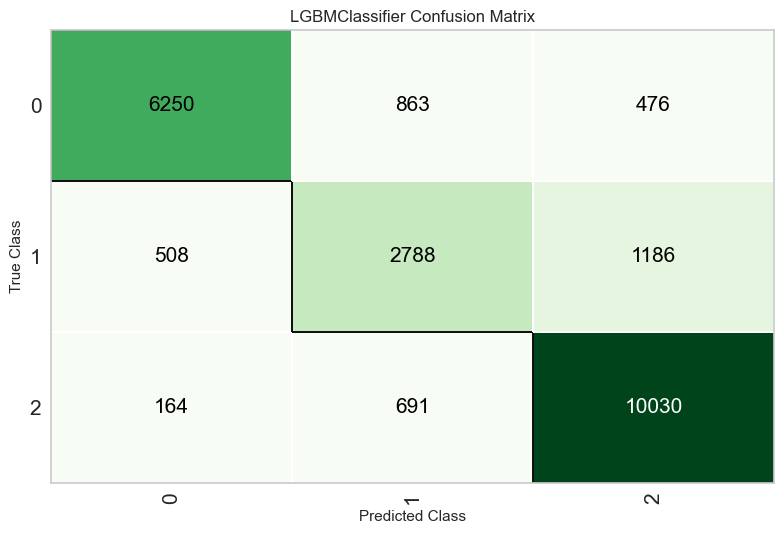

In [64]:
# Visualización del modelo
plot_model(tuned_dt, plot='confusion_matrix')

In [65]:
# Visualización exhaustiva del modelo
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [66]:
# Evaluar el modelo en el conjunto de prueba
predictions_test = predict_model(tuned_dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8306,0.9440,0.8306,0.8306,0.8295,0.7277,0.7289


In [67]:
predictions_train = predict_model(tuned_dt, data=exp_clf101.get_config('X_train'))

In [68]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [69]:
from sklearn.metrics import accuracy_score
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test["prediction_label"]))

0.8450393935999403
0.8306325143753267


## Entrenamiento del modelo completo

In [70]:
%%time
# Finalizar el modelo
final_dt = finalize_model(tuned_dt)

CPU times: total: 25.8 s
Wall time: 6.43 s


In [72]:
path2 = "C:/Users/Alber/OneDrive/Documentos/USTA 20242/INTELIGENCIA ARTIFICIAL/CORTE 1/SEMANA 6/Serving models/Streamlit/"

In [73]:
import pickle
with open(path2 + 'best_model.pkl', 'wb') as model_file:
    pickle.dump(final_dt, model_file)

## Predicción nuevos datos

In [74]:
# Variables cuantitativas (Activar D1)
D1 = prueba.get(cuantitativas).copy()

# Variables categóricas
D2 = prueba.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]

# Interacción cuantitativa vs categórica
D5 = prueba.copy()
contador = 0
for k in result4:
  col1, col2 = k[1], k[0] # categórica, cuantitativa
  if contador == 0:
    D51 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D51.columns:
      D51[j] = D51[j] * D5[col2]
    D51.columns = [col2+"_"+col1+"_"+ str(x) for x in D51.columns]
  else:
    D52 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D52.columns:
      D52[j] = D52[j] * D5[col2]
    D52.columns = [col2+"_"+col1+"_"+ str(x) for x in D52.columns]
    D51 = pd.concat([D51,D52],axis=1)
  contador = contador + 1

In [75]:
B1 = pd.concat([D1,D4],axis=1)
base_modelo2 = pd.concat([B1,D51],axis=1)
base_modelo2.head(3)

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Tuition fees up to date,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1
0,9500,1,141.0,3,1,152.1,18,0,7,0,...,C0,C0,C0,C0,C0_C0,C0_C0,C0_C0,0,0,0
1,9238,1,128.0,1,19,116.5,19,0,6,7,...,C1,C0,C0,C0,C1_C0,C0_C1,C0_C0,6,6,6
2,9238,1,118.0,1,19,114.2,18,0,6,11,...,C1,C0,C1,C0,C1_C1,C0_C1,C0_C1,5,11,6


In [76]:
df_test = base_modelo2.copy()
column_types = df_test.dtypes
print(column_types)

Course                                                                             int64
Previous qualification                                                             int64
Previous qualification (grade)                                                   float64
Mother's qualification                                                             int64
Father's qualification                                                             int64
Admission grade                                                                  float64
Age at enrollment                                                                  int64
Curricular units 1st sem (credited)                                                int64
Curricular units 1st sem (enrolled)                                                int64
Curricular units 1st sem (evaluations)                                             int64
Curricular units 1st sem (approved)                                                int64
Curricular units 1st 

In [77]:
# Realizar predicciones
predictions = predict_model(final_dt, data=df_test)

In [78]:
def label_tg_inv(x):
  if x==0:
    return "Dropout"
  elif x==1:
    return "Enrolled"
  else:
    return "Graduate"

## Archivo kaggle

In [102]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result_kaggle = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions['prediction_label']
})

result_kaggle["Target"] = result_kaggle["Target"].map(label_tg_inv)
result_kaggle.head(5)

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled


In [103]:
result_kaggle["Target"].value_counts()

Target
Graduate    26434
Dropout     15135
Enrolled     9443
Name: count, dtype: int64

## Diseño de API

In [83]:
prueba.iloc[0,]

id                                                76518
Marital status                                        1
Application mode                                      1
Application order                                     1
Course                                             9500
Daytime/evening attendance                            1
Previous qualification                                1
Previous qualification (grade)                    141.0
Nacionality                                           1
Mother's qualification                                3
Father's qualification                                1
Mother's occupation                                   2
Father's occupation                                   3
Admission grade                                   152.1
Displaced                                             0
Educational special needs                             0
Debtor                                                0
Tuition fees up to date                         

In [85]:
Marital_status = 1 ## select box [1 2 4 5 6 3]
Application_mode = 1 ## select box [1 44 39 17 16 42 18 7 15 43 53 51 5 10 14 27 2 35 19 3]
Application_order = 1 ## select box [1 4 2 3 6 5 9 0]
Course = 9500
Daytime = 1 ## select box [1 0]
Previous_qualification =  1
Previous_grade = 141.0
Nacionality = 1 ## select box [1 41 22 109 100 21 6 26 11 105 62 2 32 24 103 25 101 14]
Mother_qua = 3
Father_qua =  1
Mother_occ = 2 ## select box [2 4 3 5 9 7 90 1 0 6 8 99 151 141 191 10 194 144 123 134 173 193 152 153
# 192 143 175 171 132 131 154 124 125 133 122 174 98 181]
Father_occ = 3 ## select box [3 5 9 8 7 6 10 90 1 2 0 4 120 99 161 171 193 123 144 103 194 192 182 175
# 143 114 163 183 102 181 153 131 172 101 134 135 121 174 141 152 112 122
# 151 154 11 125 113 124 195]
Admission_grade = 152.1
Displaced = 0 ## select box [0 1]
Educational_special = 0 ## select box [0 1]
Debtor = 0 ## select box [0 1]
Tuition = 0 ## select box [0 1]
Gender =  0 ## select box [0 1]
Scholarship_holder =  0 ## select box [0 1]
Age_at =  18
International = 0 ## select box [0 1]
Curricular_1st_credit =  0
Curricular_1st_enr = 7
Curricular_1st_eval = 0
Curricular_1st_app = 0
Curricular_1st_grade =  0.0
Curricular_1st_without = 0
Curricular_2nd_credited = 0
Curricular_2nd_enrolled =  8
Curricular_2nd_eval = 0
Curricular_2nd_approved = 0
Curricular_2nd_grade = 0.0
Curricular_2nd_without =  0
Unemployment_rate = 13.9
Inflation_rate = -0.3
GDP = 0.79

In [86]:
for k in categoricas:
    print("Variable",k)
    print(prueba[k].unique())

Variable Marital status
[1 2 4 5 6 3]
Variable Application mode
[1 44 39 17 16 42 18 7 15 43 53 51 5 10 14 27 2 35 19 3]
Variable Application order
[1 4 2 3 6 5 9 0]
Variable Daytime/evening attendance
[1 0]
Variable Nacionality
[1 41 22 109 100 21 6 26 11 105 62 2 32 24 103 25 101 14]
Variable Mother's occupation
[2 4 3 5 9 7 90 1 0 6 8 99 151 141 191 10 194 144 123 134 173 193 152 153
 192 143 175 171 132 131 154 124 125 133 122 174 98 181]
Variable Father's occupation
[3 5 9 8 7 6 10 90 1 2 0 4 120 99 161 171 193 123 144 103 194 192 182 175
 143 114 163 183 102 181 153 131 172 101 134 135 121 174 141 152 112 122
 151 154 11 125 113 124 195]
Variable Displaced
[0 1]
Variable Educational special needs
[0 1]
Variable Debtor
[0 1]
Variable Tuition fees up to date
[0 1]
Variable Gender
[0 1]
Variable Scholarship holder
[0 1]
Variable International
[0 1]


In [92]:
user = pd.DataFrame({'x0':[0],'x1':[Marital_status],'x2': [Application_mode],
'x3': [Application_order], 'x4': [Course], 'x5': [Daytime], 'x6':[Previous_qualification],
'x7':[Previous_grade], 'x8': [Nacionality], 'x9': [Mother_qua], 'x10':[Father_qua],
'x11': [Mother_occ], 'x12': [Father_occ], 'x13': [Admission_grade],
'x14': [Displaced], 'x15': [Educational_special], 'x16': [Debtor],
'x17': [Tuition], 'x18': [Gender], 'x19': [Scholarship_holder],
'x20': [Age_at], 'x21': [International], 'x22': [Curricular_1st_credit],
'x23': [Curricular_1st_enr], 'x24': [Curricular_1st_eval],
'x25': [Curricular_1st_app], 'x26': [Curricular_1st_grade],
'x27': [Curricular_1st_without], 'x28': [Curricular_2nd_credited],
'x29': [Curricular_2nd_enrolled], 'x30': [Curricular_2nd_eval],
'x31': [Curricular_2nd_approved], 'x32': [Curricular_2nd_grade],
'x33': [Curricular_2nd_without], 'x34': [Unemployment_rate],
'x35': [Inflation_rate], 'x36':[GDP]})
user.columns = prueba.columns

In [97]:
prueba2 = pd.concat([user,prueba],axis = 0)
prueba2.index = range(prueba2.shape[0])
prueba2.head(2)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0,1,1,1,9500,1,1,141.0,1,3,...,0,0,8,0,0,0.0,0,13.9,-0.3,0.79
1,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,8,0,0,0.0,0,13.9,-0.3,0.79


In [98]:
cuantitativas

['Course',
 'Previous qualification',
 'Previous qualification (grade)',
 "Mother's qualification",
 "Father's qualification",
 'Admission grade',
 'Age at enrollment',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP']

In [99]:
categoricas

['Marital status',
 'Application mode',
 'Application order',
 'Daytime/evening attendance',
 'Nacionality',
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'International']

In [100]:
cuadrado

['Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)']

In [105]:
result

[['Admission grade', 'Curricular units 2nd sem (approved)'],
 ['Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)'],
 ['Curricular units 1st sem (approved)',
  'Curricular units 2nd sem (approved)']]

In [106]:
result2

[[('Curricular units 2nd sem (approved)',
   'Curricular units 2nd sem (enrolled)')],
 [('Curricular units 2nd sem (approved)', 'Age at enrollment')],
 [('Curricular units 2nd sem (approved)',
   'Curricular units 1st sem (enrolled)')]]

In [107]:
result3

[['Tuition fees up to date', 'Scholarship holder'],
 ['Educational special needs', 'Tuition fees up to date'],
 ['Gender', 'Scholarship holder']]

In [108]:
result4

[('Curricular units 2nd sem (approved)', 'Tuition fees up to date'),
 ('Curricular units 2nd sem (evaluations)', 'Tuition fees up to date'),
 ('Curricular units 1st sem (approved)', 'Tuition fees up to date')]

In [109]:
# Variables cuantitativas (Activar D1)
D1 = prueba2.get(cuantitativas).copy()

# Variables categóricas
D2 = prueba2.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]

# Interacción cuantitativa vs categórica
D5 = prueba.copy()
contador = 0
for k in result4:
  col1, col2 = k[1], k[0] # categórica, cuantitativa
  if contador == 0:
    D51 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D51.columns:
      D51[j] = D51[j] * D5[col2]
    D51.columns = [col2+"_"+col1+"_"+ str(x) for x in D51.columns]
  else:
    D52 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D52.columns:
      D52[j] = D52[j] * D5[col2]
    D52.columns = [col2+"_"+col1+"_"+ str(x) for x in D52.columns]
    D51 = pd.concat([D51,D52],axis=1)
  contador = contador + 1

In [110]:
B1 = pd.concat([D1,D4],axis=1)
base_modelo2 = pd.concat([B1,D51],axis=1)
base_modelo2.head(3)

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Tuition fees up to date,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1
0,9500,1,141.0,3,1,152.1,18,0,7,0,...,C0,C0,C0,C0,C0_C0,C0_C0,C0_C0,0.0,0.0,0.0
1,9500,1,141.0,3,1,152.1,18,0,7,0,...,C0,C0,C0,C0,C0_C0,C0_C0,C0_C0,6.0,6.0,6.0
2,9238,1,128.0,1,19,116.5,19,0,6,7,...,C1,C0,C0,C0,C1_C0,C0_C1,C0_C0,5.0,11.0,6.0


In [113]:
# Carga el modelo desde el archivo
with open(path2 + 'best_model.pkl', 'rb') as model_file:
    dt2 = pickle.load(model_file)

In [116]:
df_test = base_modelo2.copy()
predictions = predict_model(dt2, data=df_test)
predictions.head()

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1,prediction_label,prediction_score
0,9500,1,141.0,3,1,152.100006,18,0,7,0,...,C0,C0,C0_C0,C0_C0,C0_C0,0.0,0.0,0.0,0,0.9918
1,9500,1,141.0,3,1,152.100006,18,0,7,0,...,C0,C0,C0_C0,C0_C0,C0_C0,6.0,6.0,6.0,0,0.9211
2,9238,1,128.0,1,19,116.500000,19,0,6,7,...,C0,C0,C1_C0,C0_C1,C0_C0,5.0,11.0,6.0,2,0.9619
3,9238,1,118.0,1,19,114.199997,18,0,6,11,...,C1,C0,C1_C1,C0_C1,C0_C1,5.0,14.0,5.0,2,0.7180
4,9147,39,130.0,1,19,130.000000,23,2,6,15,...,C1,C0,C1_C1,C0_C1,C0_C1,4.0,9.0,3.0,1,0.4863


In [117]:
predictions["Target"] = predictions["prediction_label"].map(label_tg_inv)
predictions.head()

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (approved)_Tuition fees up to date_1,Curricular units 2nd sem (evaluations)_Tuition fees up to date_1,Curricular units 1st sem (approved)_Tuition fees up to date_1,prediction_label,prediction_score,Target
0,9500,1,141.0,3,1,152.100006,18,0,7,0,...,C0,C0_C0,C0_C0,C0_C0,0.0,0.0,0.0,0,0.9918,Dropout
1,9500,1,141.0,3,1,152.100006,18,0,7,0,...,C0,C0_C0,C0_C0,C0_C0,6.0,6.0,6.0,0,0.9211,Dropout
2,9238,1,128.0,1,19,116.500000,19,0,6,7,...,C0,C1_C0,C0_C1,C0_C0,5.0,11.0,6.0,2,0.9619,Graduate
3,9238,1,118.0,1,19,114.199997,18,0,6,11,...,C0,C1_C1,C0_C1,C0_C1,5.0,14.0,5.0,2,0.7180,Graduate
4,9147,39,130.0,1,19,130.000000,23,2,6,15,...,C0,C1_C1,C0_C1,C0_C1,4.0,9.0,3.0,1,0.4863,Enrolled


In [119]:
print('La predicción es :',predictions.iloc[0,]["Target"])

La predicción es : Dropout


## Guardar archivo kaggle

In [ ]:
# Save the result to a CSV file
result_kaggle.to_csv(path + 'subbmision_albert.csv', index=False,sep=",")

In [ ]:
# Guardar y cargar modelos
save_model(final_dt, path + 'final_dt_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt_model_customer_churn')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


## Carga directa

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/INTELIGENCIA ARTIFICIAL/PARCIAL 1/"

In [ ]:
pip install --upgrade kaggle

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Configurar las credenciales de Kaggle
os.environ['KAGGLE_USERNAME'] = 'albertstats1988'
os.environ['KAGGLE_KEY'] = 'e1c23ee858429bae18536e17c0f41495'

# Crear instancia de la API de Kaggle y autenticar
api = KaggleApi()
api.authenticate()

# Aceptar las reglas de la competencia (intenta este paso primero)
competition_name = 'playground-series-s4e6'

# Descargar los archivos de la competencia
download_path = 'data/'
api.competition_download_files(competition_name, path=download_path)

# Descomprimir los archivos descargados
import zipfile
for item in os.listdir(download_path):
    if item.endswith('.zip'):
        zip_ref = zipfile.ZipFile(os.path.join(download_path, item), 'r')
        zip_ref.extractall(download_path)
        zip_ref.close()
        print(f"Unzipped {item}")

Unzipped playground-series-s4e6.zip


In [ ]:
path

'/content/drive/MyDrive/Colab Notebooks/INTELIGENCIA ARTIFICIAL/PARCIAL 1/'

In [ ]:
api.competition_submit(file_name=path + "subbmision_albert.csv",
message="First submission",
competition="playground-series-s4e6")

100%|██████████| 759k/759k [00:00<00:00, 1.56MB/s] 


Successfully submitted to Classification with an Academic Success Dataset